<a href="https://colab.research.google.com/github/maglili/ai_cup-meddialog/blob/main/bert_base_crf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Preprocessing

In [ ]:
%%capture
!pip install transformers seqeval pytorch-crf

In [ ]:
import pandas as pd
import numpy as np
from tqdm import trange
from tqdm.notebook import tqdm
from seqeval.metrics import classification_report

全形轉半形function

In [ ]:
def strQ2B(ustring):
    """把字串全形轉半形"""
    ss = []
    for s in ustring:
        rstring = ""
        for uchar in s:
            inside_code = ord(uchar)
            if inside_code == 12288:  # 全形空格直接轉換
                inside_code = 32
            elif (inside_code >= 65281 and inside_code <= 65374):  # 全形字元（除空格）根據關係轉化
                inside_code -= 65248
            rstring += chr(inside_code)
        ss.append(rstring)
    return ''.join(ss)

Reading data and split data into sections, strores data in section_list.

In [ ]:
with open('/content/drive/MyDrive/Projects/AI_CUP-meddialog/train_2.txt',encoding='utf-8-sig') as fh:
  all_word = fh.read()
  all_word = strQ2B(all_word)
  section_list = all_word.strip().split('--------------------')# a list contain all section word

#　remove blank
while True:
  if '' in section_list:
    section_list.remove('')
  else:
    break

Storing section text and it's label in data_text and data_label separately.

In [ ]:
data_text=[]
data_label=[]
tag_values=[] #記錄所有不同種類的label (e.g time、med、location...)

for section in section_list:
  rows = section.strip().split('\n') # 在一個片段(section)中的所有row
  text = rows[0].lower() # 第一行是醫病對話
  text_label = ['O'] * len(text) # 把text_label初始化，list length = text length
  if 'O' not in tag_values:
    tag_values.append('O')

  for i in range(2,len(rows)):
    row = rows[i].strip().split('\t') # list that containing all elements in a row
    text_label[int(row[1])] = 'B-'+row[4]
    if 'B-'+row[4] not in tag_values:
      tag_values.append('B-'+row[4])
    for i in range(int(row[1])+1, int(row[2])):
      text_label[i] = 'I-'+row[4]
      if 'I-'+row[4] not in tag_values:
        tag_values.append('I-'+row[4])
  data_text.append(text)
  data_label.append(text_label)

In [ ]:
data_text[:5]

['醫師:啊回去還好嗎?民眾:欸,還是虛虛的,但。醫師:欸,真的。民眾:好險好險。坦白講我剛回去的時候晚上還是有盜汗。醫師:盜汗。民眾:阿只是前天好很多。前天就算沒盜,可是一覺到天明這樣。醫師:一覺到天明齁。我給你看電腦斷層齁。民眾:嘿。還有那個病毒報告不知道出來沒。醫師:病毒齁。民眾:對對對。醫師:它有幫你驗了不少,還有自體免疫呢。民眾:喔。醫師:我相信你之前都驗過。民眾:對阿。醫師:哇,不過你工作壓力很大欸,得潰瘍。民眾:欸,真的阿。醫師:自體免疫,還好。民眾:negative。醫師:negative,阿這個是?民眾:皰疹。醫師:皰疹病毒的抗體也是negative。民眾:嗯嗯嗯。醫師:啊q熱陰性,然後第一次檢查綜合結果也是陰性。民眾:所謂q熱就是那種蚊蟲叮咬的。醫師:嘿,跟動物阿、跳蚤那些比較有相關。民眾:了解。醫師:然後恙蟲病,需再採檢。沒關係我們到時候要追蹤再一起送疾管區。民眾:可以啊,可以啊。醫師:恙蟲病我覺得機會少。民眾:對。醫師:因為恙蟲病要有恙蟲。民眾:對阿。醫師:恙蟲是在離島比較多,山區。民眾:喔,了解了解。醫師:然後,斑疹傷寒就是跟跳蚤比較有關係,外病啦。民眾:嗯,對對對。醫師:比較少見的。民眾:了解了解。醫師:然後ebv,喔,還有cmv病毒也都ok。民眾:這是什麼東西啊。醫師:就是,病毒會引起你肝功能異常的。ebv還有cmv,巨細胞病毒。民眾:嗯。醫師:這是良性的。民眾:喔,這是良性的。醫師:嘿,這都是良性的,自己會好。阿但是會讓你發燒。民眾:嗯。醫師:一陣子這樣子,嗯。民眾:阿這也是都沒有?醫師:都沒有的樣子。我們還驗了些什麼,直接調出來看。民眾:嗯。醫師:阿不過你來的時候發炎指數比較高。發炎指數比較高,crp。然後肝功能比較異常,85,102。民眾:這個可能是沒睡好。醫師:也有可能。你有沒有喝酒應酬?民眾:喝酒,其實一陣子沒有了欸。醫師:一陣子沒有。民眾:對。你說假如是前年,那有可能,但是去年可能。醫師:就沒有。民眾:對阿。因為老實講,我前年都在對岸比較多。醫師:喔,前年。民眾:對。醫師:它,google有設廠喔?民眾:欸,客戶在那邊。醫師:客戶在那邊。民眾:對對,阿也有設廠,也有設廠。醫師:你是做,跑業務這樣子。民眾:對對對。醫師:google不是,那做什麼,abs?民眾:abs。abs阿,跟那個壓克力。醫師:壓克力這樣子。所以我,我們,

In [ ]:
text_id = 0
print(data_text[text_id])
print(data_label[text_id])
print('len of data_text[{}]:'.format(text_id), len(data_text[text_id]))
print('len of data_label[{}]:'.format(text_id), len(data_label[text_id]))

醫師:啊回去還好嗎?民眾:欸,還是虛虛的,但。醫師:欸,真的。民眾:好險好險。坦白講我剛回去的時候晚上還是有盜汗。醫師:盜汗。民眾:阿只是前天好很多。前天就算沒盜,可是一覺到天明這樣。醫師:一覺到天明齁。我給你看電腦斷層齁。民眾:嘿。還有那個病毒報告不知道出來沒。醫師:病毒齁。民眾:對對對。醫師:它有幫你驗了不少,還有自體免疫呢。民眾:喔。醫師:我相信你之前都驗過。民眾:對阿。醫師:哇,不過你工作壓力很大欸,得潰瘍。民眾:欸,真的阿。醫師:自體免疫,還好。民眾:negative。醫師:negative,阿這個是?民眾:皰疹。醫師:皰疹病毒的抗體也是negative。民眾:嗯嗯嗯。醫師:啊q熱陰性,然後第一次檢查綜合結果也是陰性。民眾:所謂q熱就是那種蚊蟲叮咬的。醫師:嘿,跟動物阿、跳蚤那些比較有相關。民眾:了解。醫師:然後恙蟲病,需再採檢。沒關係我們到時候要追蹤再一起送疾管區。民眾:可以啊,可以啊。醫師:恙蟲病我覺得機會少。民眾:對。醫師:因為恙蟲病要有恙蟲。民眾:對阿。醫師:恙蟲是在離島比較多,山區。民眾:喔,了解了解。醫師:然後,斑疹傷寒就是跟跳蚤比較有關係,外病啦。民眾:嗯,對對對。醫師:比較少見的。民眾:了解了解。醫師:然後ebv,喔,還有cmv病毒也都ok。民眾:這是什麼東西啊。醫師:就是,病毒會引起你肝功能異常的。ebv還有cmv,巨細胞病毒。民眾:嗯。醫師:這是良性的。民眾:喔,這是良性的。醫師:嘿,這都是良性的,自己會好。阿但是會讓你發燒。民眾:嗯。醫師:一陣子這樣子,嗯。民眾:阿這也是都沒有?醫師:都沒有的樣子。我們還驗了些什麼,直接調出來看。民眾:嗯。醫師:阿不過你來的時候發炎指數比較高。發炎指數比較高,crp。然後肝功能比較異常,85,102。民眾:這個可能是沒睡好。醫師:也有可能。你有沒有喝酒應酬?民眾:喝酒,其實一陣子沒有了欸。醫師:一陣子沒有。民眾:對。你說假如是前年,那有可能,但是去年可能。醫師:就沒有。民眾:對阿。因為老實講,我前年都在對岸比較多。醫師:喔,前年。民眾:對。醫師:它,google有設廠喔?民眾:欸,客戶在那邊。醫師:客戶在那邊。民眾:對對,阿也有設廠,也有設廠。醫師:你是做,跑業務這樣子。民眾:對對對。醫師:google不是,那做什麼,abs?民眾:abs。abs阿,跟那個壓克力。醫師:壓克力這樣子。所以我,我們,我們

把 label 轉成 id

In [ ]:
tag_values.append("PAD")
tag2idx = {t: i for i, t in enumerate(tag_values)}
tag2idx

{'B-ID': 13,
 'B-clinical_event': 15,
 'B-contact': 21,
 'B-education': 17,
 'B-family': 11,
 'B-location': 9,
 'B-med_exam': 3,
 'B-money': 19,
 'B-name': 7,
 'B-organization': 23,
 'B-others': 25,
 'B-profession': 5,
 'B-time': 1,
 'I-ID': 14,
 'I-clinical_event': 16,
 'I-contact': 22,
 'I-education': 18,
 'I-family': 12,
 'I-location': 10,
 'I-med_exam': 4,
 'I-money': 20,
 'I-name': 8,
 'I-organization': 24,
 'I-others': 26,
 'I-profession': 6,
 'I-time': 2,
 'O': 0,
 'PAD': 27}

check data

In [ ]:
# should be same
print('length of section_list:',len(section_list))
print('length of text list:', len(data_text))
print('length of label list:', len(data_label))

length of section_list: 200
length of text list: 200
length of label list: 200


把data_text中的文章，切成 character 儲存在 all_char_list

In [ ]:
all_char_list=[] # store all character_set
for paragraph in data_text:
  character_set = [] # store a single text, text is split to character
  for char in paragraph:
    character_set.append(char)
  all_char_list.append(character_set)
len(all_char_list) # total paragraph

200

儲存所有的短句，用句號分隔

In [ ]:
all_chunks_text=[] # 儲存所有的小句子
all_chunks_label=[] # 儲存所有的小句子對應的label

for paragraph_id, paragraph in enumerate(all_char_list):
  chunks_text=[] # 用來儲存小短句子，以句號"。"為分界
  chunks_label=[]
  for index, character in enumerate(paragraph):
    chunks_text.append(character)
    chunks_label.append(data_label[paragraph_id][index])
    if character == '。':
      all_chunks_text.append(chunks_text) 
      chunks_text=[]

      all_chunks_label.append(chunks_label)
      chunks_label=[]

In [ ]:
print(len(all_chunks_text))
print(len(all_chunks_label))

20379
20379


查看最長的句子有多長

In [ ]:
max_len = 0
for i in all_chunks_text:
  if len(i) > max_len:
    max_len = len(i)
    #print(i)
    print('length of i:',len(i))
    print('-'*10)

length of i: 23
----------
length of i: 25
----------
length of i: 27
----------
length of i: 28
----------
length of i: 33
----------
length of i: 41
----------
length of i: 45
----------
length of i: 55
----------
length of i: 56
----------
length of i: 202
----------
length of i: 209
----------
length of i: 242
----------
length of i: 299
----------
length of i: 321
----------
length of i: 546
----------


In [ ]:
max_len = 0
a = b = c = d = e = f = 0
for i in all_chunks_text:
  if 50 > len(i) >= 0:
    a += 1
  elif 100 > len(i) >= 50:
    b += 1
  elif 150 > len(i) >= 100:
    c += 1 
  elif 200 > len(i) >= 150:
    d += 1
  elif 250 > len(i) >= 200:
    e += 1
  else:
    f += 1
print('50> len:',a)
print('100> len >= 50:',b)
print('100> len >= 50:',c)
print('200> len >= 150:',d)
print('250> len >= 200:',e)
print('len >= 250:',f)

50> len: 19016
100> len >= 50: 1190
100> len >= 50: 127
200> len >= 150: 26
250> len >= 200: 11
len >= 250: 9


## Apply BERT
Prepare the sentences and labels

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
torch.manual_seed(0)
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertConfig

from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

In [ ]:
MAX_LEN = 250
bs = 32

In [ ]:
if torch.cuda.is_available():
    device = torch.device('cuda')
    print('Working on GPU')
else:
    device = torch.device('cpu')
    print('Working on CPU')
n_gpu = torch.cuda.device_count()

Working on GPU


In [ ]:
torch.cuda.get_device_name(0)

'Tesla T4'

In [ ]:
!nvidia-smi

Fri Jan  8 13:55:41 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.27.04    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P8     9W /  70W |     10MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
tokenizer = BertTokenizer.from_pretrained("bert-base-chinese")

Now we tokenize all sentences. Since the BERT tokenizer is based a Wordpiece tokenizer it will split tokens in subword tokens. For example ‘gunships’ will be split in the two tokens ‘guns’ and ‘##hips’. We have to deal with the issue of splitting our token-level labels to related subtokens. In practice you would solve this by a specialized data structure based on label spans, but for simplicity I do it explicitly here.

In [ ]:
def tokenize_and_preserve_labels(sentence, text_labels):
    tokenized_sentence = []
    labels = []

    for word, label in zip(sentence, text_labels):

        # Tokenize the word and count # of subwords the word is broken into
        tokenized_word = tokenizer.tokenize(word)
        n_subwords = len(tokenized_word)

        # Add the tokenized word to the final tokenized word list
        tokenized_sentence.extend(tokenized_word)

        # Add the same label to the new list of labels `n_subwords` times
        labels.extend([label] * n_subwords)

    return tokenized_sentence, labels

In [ ]:
tokenized_texts_and_labels = [
    tokenize_and_preserve_labels(sent, labs)
     for sent, labs in zip(all_chunks_text, all_chunks_label) #if labs != ['O']*len(labs)
]

In [ ]:
len(tokenized_texts_and_labels)

20379

check data

In [ ]:
num_id = 25
for i in range(len(tokenized_texts_and_labels[num_id][0])):
  print('{} : {}'.format(tokenized_texts_and_labels[num_id][0][i], tokenized_texts_and_labels[num_id][1][i]))

民 : O
眾 : O
: : O
所 : O
謂 : O
q : O
熱 : O
就 : O
是 : O
那 : O
種 : O
蚊 : O
蟲 : O
叮 : O
咬 : O
的 : O
。 : O


In [ ]:
tokenized_texts = [token_label_pair[0] for token_label_pair in tokenized_texts_and_labels]
labels = [token_label_pair[1] for token_label_pair in tokenized_texts_and_labels]

Next, we cut and pad the token and label sequences to our desired length.

In [ ]:
input_ids = pad_sequences([tokenizer.convert_tokens_to_ids(txt) for txt in tokenized_texts],
                          maxlen=MAX_LEN, dtype="long", value=0.0,
                          truncating="post", padding="post")

In [ ]:
tags = pad_sequences([[tag2idx.get(l) for l in lab] for lab in labels],
                     maxlen=MAX_LEN, value=tag2idx["PAD"], padding="post",
                     dtype="long", truncating="post")

The Bert model supports something called attention_mask, which is similar to the masking in keras. So here we create the mask to ignore the padded elements in the sequences.

In [ ]:
attention_masks = [[float(i != 0.0) for i in ii] for ii in input_ids]

In [ ]:
tr_inputs, val_inputs, tr_tags, val_tags = train_test_split(input_ids, tags, random_state=2018, test_size=0.2)
tr_masks, val_masks, _, _ = train_test_split(attention_masks, input_ids, random_state=2018, test_size=0.2)

Since we’re operating in pytorch, we have to convert the dataset to torch tensors.

In [ ]:
tr_inputs = torch.tensor(tr_inputs)
val_inputs = torch.tensor(val_inputs)
tr_tags = torch.tensor(tr_tags)
val_tags = torch.tensor(val_tags)
tr_masks = torch.tensor(tr_masks)
val_masks = torch.tensor(val_masks)

The last step is to define the dataloaders. We shuffle the data at training time with the RandomSampler and at test time we just pass them sequentially with the SequentialSampler

In [ ]:
train_data = TensorDataset(tr_inputs, tr_masks, tr_tags)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=bs)

valid_data = TensorDataset(val_inputs, val_masks, val_tags)
valid_sampler = SequentialSampler(valid_data)
valid_dataloader = DataLoader(valid_data, sampler=valid_sampler, batch_size=bs)

## Setup the Bert model for finetuning

In [ ]:
import transformers
from transformers import BertForTokenClassification, AdamW
from transformers import BertModel
from torchcrf import CRF
transformers.__version__

'4.1.1'

In [ ]:
class Bert_CRF(nn.Module):
    def __init__(self, output_dim):
        super(Bert_CRF, self).__init__()
        self.bert = BertModel.from_pretrained("bert-base-chinese",output_attentions = False, output_hidden_states = False)
        self.dropout = nn.Dropout(p=0.1)
        self.classifier = nn.Linear(768, output_dim)
        self.crf = CRF(output_dim)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids, attention_mask)
        sequence_output = outputs[0]
        sequence_output = self.dropout(sequence_output)
        emission = self.classifier(sequence_output)
        return emission

In [ ]:
mymodel = Bert_CRF(len(tag2idx))
mymodel.to(device)

Bert_CRF(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(21128, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
   

In [ ]:
!nvidia-smi

Thu Jan  7 09:06:17 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.27.04    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    61W / 149W |    903MiB / 11441MiB |     33%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Before we can start the fine-tuning process, we have to setup the optimizer and add the parameters it should update. A common choice is the AdamW optimizer. We also add some weight_decay as regularization to the main weight matrices. If you have limited resources, you can also try to just train the linear classifier on top of BERT and keep all other weights fixed. This will still give you a good performance.

In [ ]:
FULL_FINETUNING = True
if FULL_FINETUNING:
    param_optimizer = list(mymodel.named_parameters())
    no_decay = ['bias', 'gamma', 'beta']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay_rate': 0.01},
        {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay_rate': 0.0}
    ]
else:
    param_optimizer = list(mymodel.classifier.named_parameters())
    optimizer_grouped_parameters = [{"params": [p for n, p in param_optimizer]}]

optimizer = AdamW(
    optimizer_grouped_parameters,
    lr=3e-5,
    eps=1e-8
)

We also add a scheduler to linearly reduce the learning rate throughout the epochs.

In [ ]:
from transformers import get_linear_schedule_with_warmup

epochs = 10
max_grad_norm = 1.0

# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    #num_warmup_steps=0,
    num_warmup_steps=total_steps*0.1,
    num_training_steps=total_steps
)

## Fit BERT for named entity recognition
First we define some metrics, we want to track while training. We use the f1_score from the seqeval package. You can find more details here. And we use simple accuracy on a token level comparable to the accuracy in keras.

In [ ]:
from seqeval.metrics import f1_score, accuracy_score

In [ ]:
## Store the average loss after each epoch so we can plot them.
loss_values, validation_loss_values = [], []
validation_f1 = []

for _ in tqdm(range(epochs)):
    # ========================================
    #               Training
    # ========================================
    # Perform one full pass over the training set.

    # Put the model into training mode.
    mymodel.train()
    # Reset the total loss for this epoch.
    total_loss = 0

    # Training loop
    for step, batch in enumerate(train_dataloader):
        # add batch to gpu
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        # Always clear any previously calculated gradients before performing a backward pass.
        optimizer.zero_grad()
        # forward pass
        outputs = mymodel(b_input_ids, b_input_mask)
        # get the loss
        loss = -mymodel.crf(outputs, b_labels)
        # Perform a backward pass to calculate the gradients.
        loss.backward()
        # track train loss
        total_loss += loss.item()
        # Clip the norm of the gradient
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(parameters=mymodel.parameters(), max_norm=max_grad_norm)
        # update parameters
        optimizer.step()
        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over the training data.
    avg_train_loss = total_loss / len(train_dataloader)
    print("Average train loss: {}".format(avg_train_loss))

    # Store the loss value for plotting the learning curve.
    loss_values.append(avg_train_loss)


    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    # Put the model into evaluation mode
    mymodel.eval()
    # Reset the validation loss for this epoch.
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0
    predictions , true_labels = [], []
    for batch in valid_dataloader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch

        with torch.no_grad():
            # Forward pass, calculate logit predictions.
            # This will return the logits rather than the loss because we have not provided labels.
            outputs = mymodel(b_input_ids, b_input_mask)
        # Move logits and labels to CPU
        logits = outputs.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences.
        eval_loss += -mymodel.crf(outputs, b_labels).item()
        predictions.extend([list(p) for p in np.argmax(logits, axis=2)])
        true_labels.extend(label_ids)

    eval_loss = eval_loss / len(valid_dataloader)
    validation_loss_values.append(eval_loss)
    print("Validation loss: {}".format(eval_loss))

    pred_tags = [tag_values[p_i] for p, l in zip(predictions, true_labels) for p_i, l_i in zip(p, l) if tag_values[l_i] != "PAD"]
    valid_tags = [tag_values[l_i] for l in true_labels for l_i in l if tag_values[l_i] != "PAD"]
    
    print("Validation Accuracy: {}".format(accuracy_score([valid_tags], [pred_tags])))
    print("Validation F1-Score: {}".format(f1_score([valid_tags], [pred_tags])))
    validation_f1.append(f1_score([valid_tags], [pred_tags]))
    print()
print(classification_report([valid_tags], [pred_tags]))

Average train loss: 2400.0938705444337
Validation loss: 30.916688323020935
Validation Accuracy: 0.9866684393734287
Validation F1-Score: 0.6390278770550394

Average train loss: 26.916574365952435
Validation loss: 26.88853633403778
Validation Accuracy: 0.9858223747824405
Validation F1-Score: 0.6773504273504274

Average train loss: 17.52116917628868
Validation loss: 24.827872157096863
Validation Accuracy: 0.988445175014504
Validation F1-Score: 0.7107344632768362

Average train loss: 12.611116506539139
Validation loss: 22.946033239364624
Validation Accuracy: 0.9908625024173274
Validation F1-Score: 0.7493734335839599

Average train loss: 8.272001318838083
Validation loss: 37.03463625907898
Validation Accuracy: 0.9908987623283697
Validation F1-Score: 0.7717996289424861

Average train loss: 6.855562681310317
Validation loss: 46.37999898195267
Validation Accuracy: 0.9903790369367628
Validation F1-Score: 0.7665036674816627

Average train loss: 4.065670985801547
Validation loss: 52.8584761619567

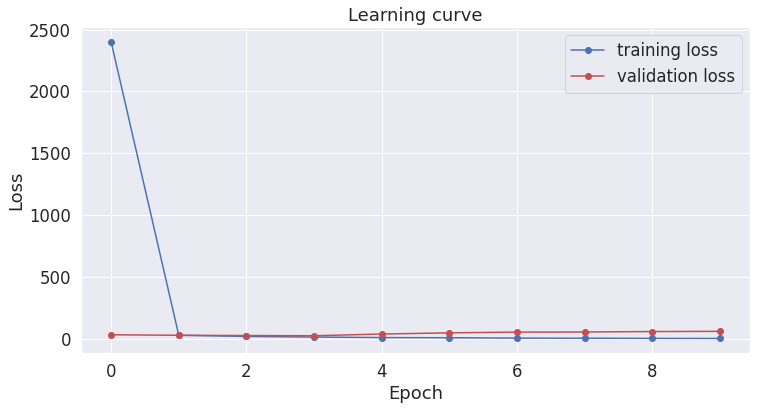

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(loss_values, 'b-o', label="training loss")
plt.plot(validation_loss_values, 'r-o', label="validation loss")

# Label the plot.
plt.title("Learning curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.show()


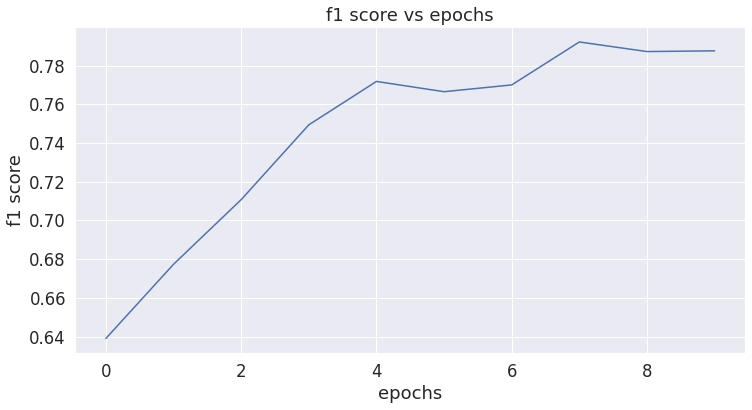

In [ ]:
plt.plot(validation_f1)
plt.xlabel('epochs')
plt.ylabel('f1 score')
plt.title('f1 score vs epochs')
plt.show()

### save model

In [ ]:
torch.save(mymodel, '/content/drive/MyDrive/Projects/AI_CUP-meddialog/model/roberta/roberta-crf_full_10epo-bs16.pt')

In [ ]:
# Model class must be defined somewhere
model = torch.load('/content/drive/MyDrive/Projects/AI_CUP-meddialog/model/roberta/roberta-crf_full_10epo-bs16.pt')
model.to(device)
model.eval();

## apply the model to a new sentence

In [ ]:
test_sentence = """
醫師：榮總醫院在十月21日於泰山區辦老人免費健檢活動。民眾:好，我明天會去看看，謝謝。 
"""
test_sentence=strQ2B(test_sentence)
tokenized_sentence = []
for word in test_sentence:
  tokenized_word = tokenizer.tokenize(word)
  tokenized_sentence.extend(tokenized_word)
test_sentence = tokenized_sentence

In [ ]:
tokenized_sentence = tokenizer.encode(test_sentence)
input_ids = torch.tensor([tokenized_sentence]).cuda()

In [ ]:
with torch.no_grad():
    output = mymodel(input_ids,attention_mask=None)
label_indices = np.argmax(output[0].to('cpu').numpy(), axis=1)

In [ ]:
# join bpe split tokens
tokens = tokenizer.convert_ids_to_tokens(input_ids.to('cpu').numpy()[0])
new_tokens, new_labels = [], []
for token, label_idx in zip(tokens, label_indices):
    if token.startswith("##"):
        new_tokens[-1] = new_tokens[-1] + token[2:]
    else:
        new_labels.append(tag_values[label_idx])
        new_tokens.append(token)

In [ ]:
for i in range(len(new_tokens)):
  print(new_tokens[i], new_labels[i])

[CLS] O
醫 O
師 O
: O
榮 B-location
總 I-location
醫 I-location
院 I-location
在 O
十 B-time
月 I-time
2 I-time
1 I-time
日 I-time
於 O
泰 B-location
山 I-location
區 I-location
辦 O
老 O
人 O
免 O
費 O
健 O
檢 O
活 O
動 O
。 O
民 O
眾 O
: O
好 O
, O
我 O
明 B-time
天 I-time
會 O
去 O
看 O
看 O
, O
謝 O
謝 O
。 O
[SEP] PAD


## output answer

In [ ]:
with open('/content/drive/MyDrive/Projects/AI_CUP-meddialog/test.txt',encoding='utf-8-sig') as fh:
  all_word = fh.read()
  section_list = all_word.strip().split('--------------------')# a list contain all section word
  
#　remove blank
while True:
  if '' in section_list:
    section_list.remove('')
  else:
    break

In [ ]:
data_text=[]
for section in section_list:
  rows = section.strip().split('\n') # 在一個片段(section)中的所有row
  data_text.append(strQ2B(rows[1].lower()))
data_text[:10]

['醫師:最近人有沒有什麼不舒服?民眾:沒有。醫師:沒有喔。我們本來說要月,年底才打對不對?民眾:對,但……醫師:你是怕?民眾:因為我要治療牙,開始要治療牙齒了。醫師:喔。民眾:啊我又不常跑醫院。醫師:喔。民眾:我想說那先來打,我今天來領藥嘛,那順便過來打。醫師:喔,是是是。啊你是要做?民眾:植牙。醫師:植牙的。民眾:對對對。醫師:喔。啊你的免疫力是夠,是沒有問題的。在我們這裡做的嗎?民眾:對,在新樓做的。醫師:诶?那這樣離你住的地方也有點距離欸,你是住麻豆嗎?民眾:對,住麻豆。醫師:那辛苦了欸,那我們就去,等下就去打針這樣子。啊沒什麼不舒服啦齁?最近?民眾:沒有,都沒有。醫師:啊最近,今年都是打四價的。民眾:喔。醫師:嗯。各個廠牌都有啦,我覺得都沒差。反正我也都沒在挑的。民眾:喔。醫師:沒關係啦齁?民眾:我不知道啊,這個要……醫師:應該都ok啦,都還好,都很安全。民眾:這個你比較專業的啊。醫師:好。血壓這樣ok。不過可能打針要等一下,因為最近打的人很多。民眾:喔。醫師:嗯,很踴躍。民眾:對啊,就聽說年底可能會打不到。醫師:嗯。會這樣喔?好,有可能,假如拖到年底可能會打不完。好,那這樣我們這邊就結束了。',
 '醫師:要去上課嗎?民眾:沒有。這學期已經開始不上課了。醫師:啊今天的,呃,應該是昨天的抽血。民眾:嗯。醫師:肝、腎功能都很棒。民眾:嗯嗯。醫師:肌酐酸,0.79,換算成腎絲球過濾率預測值是88。民眾:嗯嗯。醫師:啊這個通常60以上就夠了。民眾:60。醫師:這個都很讚。民眾:謝謝。醫師:啊ast/alt就是我們常講的got還有gpt。民眾:嗯嗯。醫師:分別是20跟19。民眾:嗯。醫師:那也是很理想。民眾:嗯。醫師:啊crp就是那個,我們那個發炎,體內發炎的時候,肝臟會分泌這個c反應蛋白。民眾:嗯。醫師:啊這個也都2.6。民眾:嗯。醫師:是大概也是ok。民眾:ok,好。醫師:那我們接下來就是等,我們就等那個……民眾:超音波。醫師:超音波做完,再來停藥這樣子。民眾:嗯。啊那個糖尿病,那個血糖那個……醫師:血糖。民眾:黃醫師說現在6.6。醫師:喔,那這樣不錯欸。民眾:6.6不錯,那時候8.3。醫師:我記得那時候8.3。民眾:四個月前8.3。醫師:所以這樣吃應該可以齁?民眾:對,可以。醫師:應該可以。民眾:看下次可不可以變6.2,說都三個月量一次。醫師:啊也不要太低啦

In [ ]:
def split_sentence_by_period(article):
  all_chunks_sent=[] # 存放所有的小句子，以句號"。"為分界
  chunks_text=[] # 佔存字元，用來組成句子
  for character in article:
    chunks_text.append(character)
    if character == '。':
      if len(chunks_text) > 510:
        chunks_text = chunks_text[:510]
      all_chunks_sent.append(chunks_text) 
      chunks_text=[]
  return all_chunks_sent

In [ ]:
def NER_eval(model, all_chunks_sent):
    setion_token=[]
    section_label=[]
    #count = 0
    for sent in all_chunks_sent:

      tokenized_sentence = tokenizer.encode(sent)
      input_ids = torch.tensor([tokenized_sentence]).cuda()

      with torch.no_grad():
        output = model(input_ids,None)
      label_indices = np.argmax(output[0].to('cpu').numpy(), axis=1)

      # join bpe split tokens
      tokens = tokenizer.convert_ids_to_tokens(input_ids.to('cpu').numpy()[0])
      new_tokens, new_labels = [], []
      for token, label_idx in zip(tokens, label_indices):
          if token.startswith("##"):
              new_tokens[-1] = new_tokens[-1] + token[2:]
          else:
              new_labels.append(tag_values[label_idx])
              new_tokens.append(token)

      setion_token += new_tokens[1:-1]
      section_label += new_labels[1:-1]

    return setion_token, section_label

In [ ]:
def handle_output(article_id,setion_token,section_label):
    start_pos=[]
    end_pos=[]
    entity_text=[]
    entity_type=[]

    for index,label in enumerate(section_label):
      #only B
      if ((label[0] == 'B')) and (section_label[index+1][0] != 'I'):
        start_pos.append(index)
        end_pos.append(index+1)
        entity_type.append(label[2:])
        entity_text.append(''.join(setion_token[start_pos[-1]:end_pos[-1]]))
      #only I
      #elif ((label[0] == 'I')) and (section_label[index-1][0] == 'O') and (section_label[index+1][0] != 'I'):
      #  start_pos.append(index)
      #  end_pos.append(index+1)
      #  entity_type.append(label[2:])
      #  entity_text.append(''.join(setion_token[start_pos[-1]:end_pos[-1]]))
      
      #先I
      #elif ((label[0] == 'I')) and (section_label[index-1][0] == 'O') and (section_label[index+1][0] == 'I'):
      #  start_pos.append(index)
      #  entity_type.append(label[2:])

      #後I(1)
      #elif ((label[0] == 'I')) and (section_label[index+1][0] != 'I') and (section_label[index-1][0] == 'I'):
      #  end_pos.append(index+1)
      #  entity_text.append(''.join(setion_token[start_pos[-1]:end_pos[-1]]))    

      #先B
      elif ((label[0] == 'B')) and (section_label[index+1][0] == 'I'):
        start_pos.append(index)
        entity_type.append(label[2:])
      #後I(2)
      elif ((label[0] == 'I')) and (section_label[index+1][0] != 'I') and ((section_label[index-1][0] == 'I') or (section_label[index-1][0] == 'B')):
     
        check_index = index
        checking = True
        next = False
        while checking:
          if section_label[check_index][0] == 'I':
            check_index -= 1
          elif section_label[check_index][0] == 'B':
            checking = False
          elif section_label[check_index][0] == 'O' or 'P':
            next = True
            checking = False
        if next:
          continue


        end_pos.append(index+1)
        entity_text.append(''.join(setion_token[start_pos[-1]:end_pos[-1]]))

    print('start_pos:',start_pos)
    print(len(start_pos))
    print('end_pos:',end_pos)
    print(len(end_pos))
    print('entity_text:',entity_text)
    print(len(entity_text))
    print('entity_type:',entity_type)
    print(len(entity_type))

    if len(start_pos) != len(end_pos) != len(entity_text) != len(entity_type):
      print('ERROR!')
      print('ERROR!')
      print('ERROR!')

    for i in range(len(start_pos)):
        writer.writerow([article_id, start_pos[i], end_pos[i], entity_text[i], entity_type[i]])
    print('-'*50)

In [ ]:
import csv
# 開啟輸出的 CSV 檔案
with open('/content/drive/MyDrive/Projects/AI_CUP-meddialog/output/roberta-crf_full_10epo-bs16.tsv', 'w', newline='\n') as csvfile:
  # 建立 CSV 檔寫入器
  writer = csv.writer(csvfile,delimiter='\t')
  # 寫入一列資料
  writer.writerow(['article_id', 'start_position', 'end_position', 'entity_text', 'entity_type'])
  count = 0
  #==========================================================
  for article_id in range(len(data_text)):
    print('[article_id = {}]'.format(article_id))

    article = data_text[article_id]

    all_chunks_sent = split_sentence_by_period(article)
    #print(all_chunks_sent)

    setion_token, section_label = NER_eval(mymodel, all_chunks_sent)
    #print(len(setion_token))
    #print(len(section_label))
    
    handle_output(article_id,setion_token,section_label)


[article_id = 0]
start_pos: [198, 227, 237]
3
end_pos: [200, 229, 239]
3
entity_text: ['新樓', '麻豆', '麻豆']
3
entity_type: ['location', 'location', 'location']
3
--------------------------------------------------
[article_id = 1]
start_pos: [15, 31, 40, 76, 94, 122, 179, 182, 258, 360, 366, 385, 394, 407, 414, 418, 463, 469, 497, 626, 663, 670, 720, 754, 867, 873, 881, 890, 902]
29
end_pos: [18, 33, 42, 80, 96, 124, 181, 184, 261, 363, 369, 388, 397, 410, 417, 421, 466, 472, 500, 629, 666, 673, 723, 757, 869, 875, 884, 893, 906]
29
entity_text: ['這學期', '今天', '昨天', '0.79', '88', '60', '20', '19', '2.6', '黃醫師', '6.6', '6.6', '8.3', '8.3', '四個月', '8.3', '6.2', '三個月', '劉老師', '黃醫師', '格里曼', '格里曼', '格里曼', '格里曼', '21', '21', '12天', '12天', '三個星期']
29
entity_type: ['time', 'time', 'time', 'med_exam', 'med_exam', 'med_exam', 'med_exam', 'med_exam', 'med_exam', 'name', 'med_exam', 'med_exam', 'med_exam', 'med_exam', 'time', 'med_exam', 'med_exam', 'time', 'name', 'name', 'name', 'name', 'name', 'name

### checking data

In [ ]:
for i in range(len(setion_token)):
  print('{} - {} : {}'.format(i, setion_token[i], section_label[i]))
#print(setion_token)
#print(section_label)

0 - 個 : O
1 - 管 : O
2 - 師 : O
3 - : : O
4 - 你 : O
5 - 上 : O
6 - 次 : O
7 - 有 : O
8 - 領 : O
9 - 了 : O
10 - 啊 : O
11 - 哈 : O
12 - 。 : O
13 - 民 : O
14 - 眾 : O
15 - : : O
16 - 我 : O
17 - 知 : O
18 - 道 : O
19 - 啊 : O
20 - 。 : O
21 - 個 : O
22 - 管 : O
23 - 師 : O
24 - : : O
25 - 你 : O
26 - 怎 : O
27 - 麼 : O
28 - 就 : O
29 - 是 : O
30 - 用 : O
31 - 後 : O
32 - 不 : O
33 - 理 : O
34 - 了 : O
35 - 呢 : O
36 - ? : O
37 - 民 : O
38 - 眾 : O
39 - : : O
40 - 不 : O
41 - 是 : O
42 - [UNK] : O
43 - [UNK] : O
44 - 醫 : O
45 - 師 : O
46 - : : O
47 - 哈 : O
48 - 哈 : O
49 - 哈 : O
50 - 哈 : O
51 - 。 : O
52 - 民 : O
53 - 眾 : O
54 - : : O
55 - 哈 : O
56 - , : O
57 - 不 : O
58 - 是 : O
59 - 啦 : O
60 - , : O
61 - 我 : O
62 - 是 : O
63 - 想 : O
64 - 說 : O
65 - [UNK] : O
66 - [UNK] : O
67 - 我 : O
68 - 是 : O
69 - 想 : O
70 - 說 : O
71 - 怎 : O
72 - 麼 : O
73 - 那 : O
74 - 麼 : O
75 - 快 : O
76 - 又 : O
77 - 要 : O
78 - 第 : O
79 - 二 : O
80 - 次 : O
81 - 了 : O
82 - 。 : O
83 - 醫 : O
84 - 師 : O
85 - : : O
86 - 所 : O
87 - 以 : O
88 - [UNK] : O
89 - [UNK] 